In [31]:
import math
import numpy as np
import tensorflow as tf
import torch
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

import matplotlib.pyplot as plt

В данном notebook'е в целях лучшего усвоения принципов и логики работы модели трансформера будет решаться задача бинарной классификации новостных текстов на фэйковые и истинные с использованием энкодера, который будет написан с нуля без импортов готовых моделей.

# Импорт данных и их предобработка

In [4]:
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

In [5]:
fake_news

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [6]:
fake_news['is_fake'] = 1
true_news['is_fake'] = 0

fake_news = fake_news[['title', 'is_fake']]
true_news = true_news[['title', 'is_fake']]

In [7]:
news_merged = pd.concat([fake_news, true_news], ignore_index=True).sample(frac=1, ignore_index=True)

In [8]:
news_merged

,title,is_fake
0,BOMBSHELL: More Women Threatened By Hillary Ar...,1
1,"Julian Assange – “Everything that he has said,...",1
2,Russia's Lavrov tells Tillerson important not ...,0
3,"COLLEGE CAMPUS BANS Chalk, Fears Students Migh...",1
4,FLASHBACK [VIDEO]: Libertarian Gary Johnson Di...,1
...,...,...
44893,MUSLIM CONGRESSMAN Abruptly Leaves DC: Uses Fi...,1
44894,Trump preparing executive orders to reduce U.S...,0
44895,Trump administration seeks prompt raise of deb...,0
44896,New Poll Shows How Batsh** CRAZY Trump Fans A...,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(news_merged['title'], news_merged['is_fake'], test_size=0.2, random_state=42, shuffle=True)

Токенизируем весь корпус из новостных текстов. Предложения разобьем на слова и найдем словарь для всего корпуса, а также определим некоторые глобальные переменные, которые понадобятся при построении модели.

In [10]:
MAX_LEN = 30 # максимальная длина предложений, предложения с большей длиной будут обрезаться, с меньшей - разница будет заполняться фиктивными нулями
PAD = 'post'
TRUNC = 'post'
EMBED_DIM = 12 # размер эмбеддинга
BATCH_SIZE = 32 # размер батча

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [12]:
tokenizer.fit_on_texts(X_train)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print("Размер словаря: ", VOCAB_SIZE)

Размер словаря:  29238


In [13]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_LEN, padding=PAD, truncating=TRUNC)

In [14]:
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_LEN, padding=PAD, truncating=TRUNC)

Функция для вычисления скалярного произведения, которая понадобится для реализации механизма self-attention

In [16]:
def scaled_dot_product_attention(query, key, value, mask=None):
    key_dim = tf.cast(tf.shape(key)[-1], tf.float32)

    scaled_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(key_dim)

    if mask is not None:
        scaled_scores = tf.where(mask==0, -np.inf, scaled_scores) #если mask != 0, то там, где она ==0 для scores будет значение -бескон.

    softmax = tf.keras.layers.Softmax()
    weights = softmax(scaled_scores)

    return tf.matmul(weights, value), weights

Реализация механизма Multi-Head-self-attention

In [17]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.d_head = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(self.d_model)  #12x12 for ex.
        self.wk = tf.keras.layers.Dense(self.d_model)  #12x12
        self.wv = tf.keras.layers.Dense(self.d_model)  #12x12

        self.dense = tf.keras.layers.Dense(self.d_model) #12x12

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]


        split_inputs = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_head)) # -1 означает, что эту размерность функция посчитает сама
        return tf.transpose(split_inputs, perm=[0, 2, 1, 3])

    def merge_heads(self, x):
        batch_size = tf.shape(x)[0]

        merged_inputs = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(merged_inputs, (batch_size, -1, self.d_model))

    def call(self, q, k, v, mask):
        qs = self.wq(q)
        ks = self.wk(k)
        vs = self.wv(v)

        qs = self.split_heads(qs)
        ks = self.split_heads(ks)
        vs = self.split_heads(vs)

        output, attn_weights = scaled_dot_product_attention(qs, ks, vs, mask) #тут и происходят умножение q на k.T, прогон через софтмакс и умножение на v
        output = self.merge_heads(output)

        return self.dense(output), attn_weights

Реализация полносвязного слоя

In [18]:
def feed_forward_network(d_model, hidden_dim):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_dim, activation='relu'),
      tf.keras.layers.Dense(d_model)
    ])

Реализация одного блока энкодера

In [19]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super(EncoderBlock, self).__init__()

        self.mhsa = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, hidden_dim)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()



    def call(self, x, training, mask):
        mhsa_output, attn_weights = self.mhsa(x, x, x, mask)
        mhsa_output = self.dropout1(mhsa_output, training=training)
        mhsa_output = self.layernorm1(x + mhsa_output)

        ffn_output = self.ffn(mhsa_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        ffn_output = self.layernorm2(mhsa_output + ffn_output)


        return ffn_output, attn_weights

Реализация итогового класса энкодера

In [20]:

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, src_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_embed = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.pos_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.blocks = [EncoderBlock(self.d_model, num_heads, hidden_dim, dropout_rate)
        for _ in range(num_blocks)]

    def call(self, input, training, mask):
        token_embeds = self.token_embed(input)

        num_pos = input.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, input.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds, training=training)

        for block in self.blocks:
            x, weights = block(x, training, mask)

        return x, weights

С энкодером закончили. Теперь напишем модель для обучения.

In [21]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,), batch_size=BATCH_SIZE)

In [22]:
encoder = Encoder(3, EMBED_DIM, 3, 48, VOCAB_SIZE, MAX_LEN)

In [23]:
enc_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)
enc_mask = enc_mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
inputs_after_encoder, weights = encoder(inputs, training=True, mask=enc_mask)

In [25]:
inputs_after_encoder = tf.keras.layers.GlobalAveragePooling1D()(inputs_after_encoder)

In [26]:
inputs_after_encoder = tf.keras.layers.Dropout(0.2)(inputs_after_encoder)

In [27]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(inputs_after_encoder)

In [28]:
model = tf.keras.models.Model(inputs, outputs)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(32, 30)]                   0         []                            
                                                                                                  
 tf.math.not_equal (TFOpLam  (32, 30)                     0         ['input_1[0][0]']             
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (32, 30)                     0         ['tf.math.not_equal[0][0]']   
                                                                                                  
 tf.__operators__.getitem (  (32, 1, 1, 30)               0         ['tf.cast[0][0]']         

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE, drop_remainder=True)

In [32]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

In [33]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.0001, patience = 2, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [34]:
tf.config.run_functions_eagerly(True)
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/5

1122/1122 [==============================] - 332s 295ms/step - loss: 0.1364 - accuracy: 0.9494 - val_loss: 0.1231 - val_accuracy: 0.9580
Epoch 2/5
1122/1122 [==============================] - 350s 312ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.0956 - val_accuracy: 0.9691
Epoch 3/5
1122/1122 [==============================] - 324s 289ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.1328 - val_accuracy: 0.9664
Epoch 4/5
1122/1122 [==============================] - 310s 277ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.1518 - val_accuracy: 0.9652
Epoch 4: early stopping


3 эпох оказалось вполне достаточно для получения высокой точности предсказаний модели.

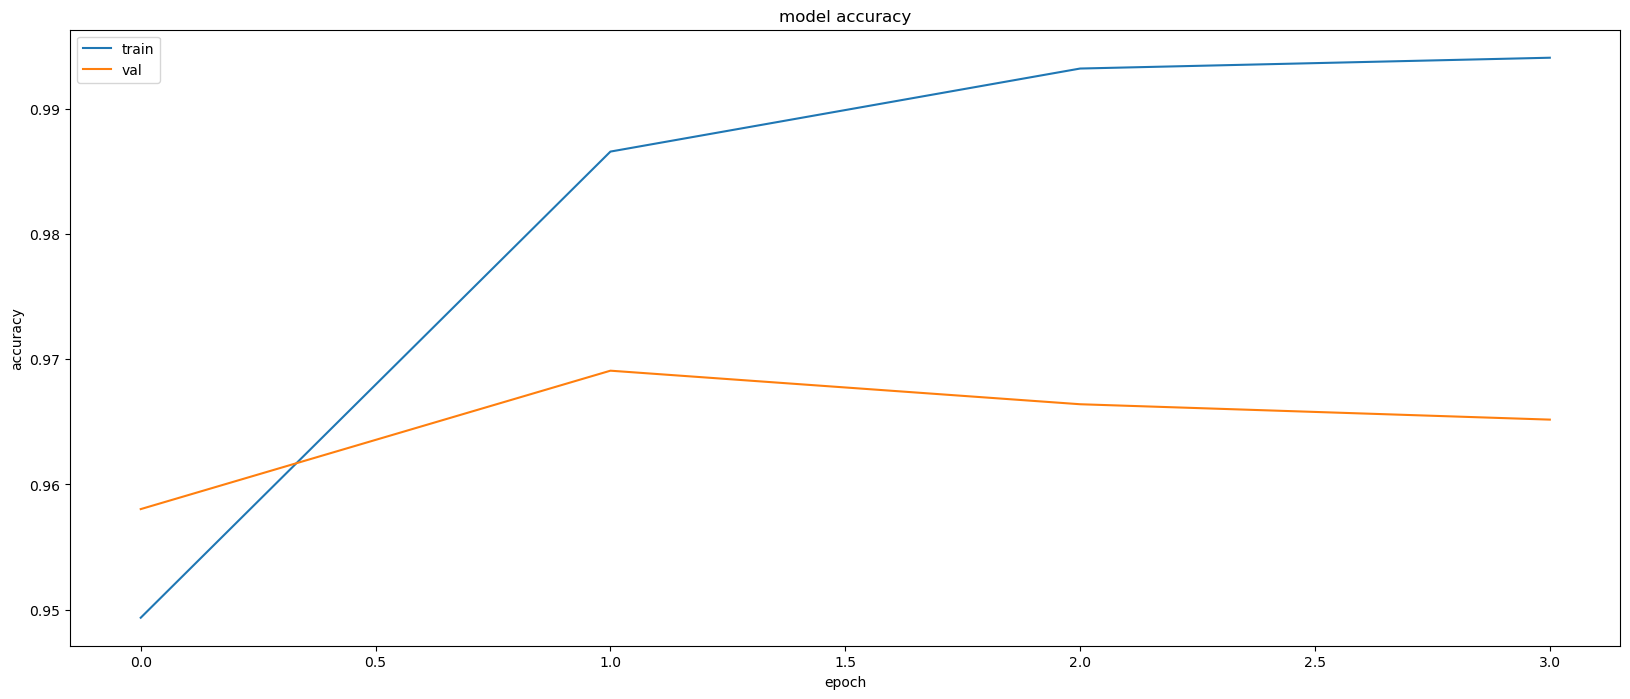

In [37]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

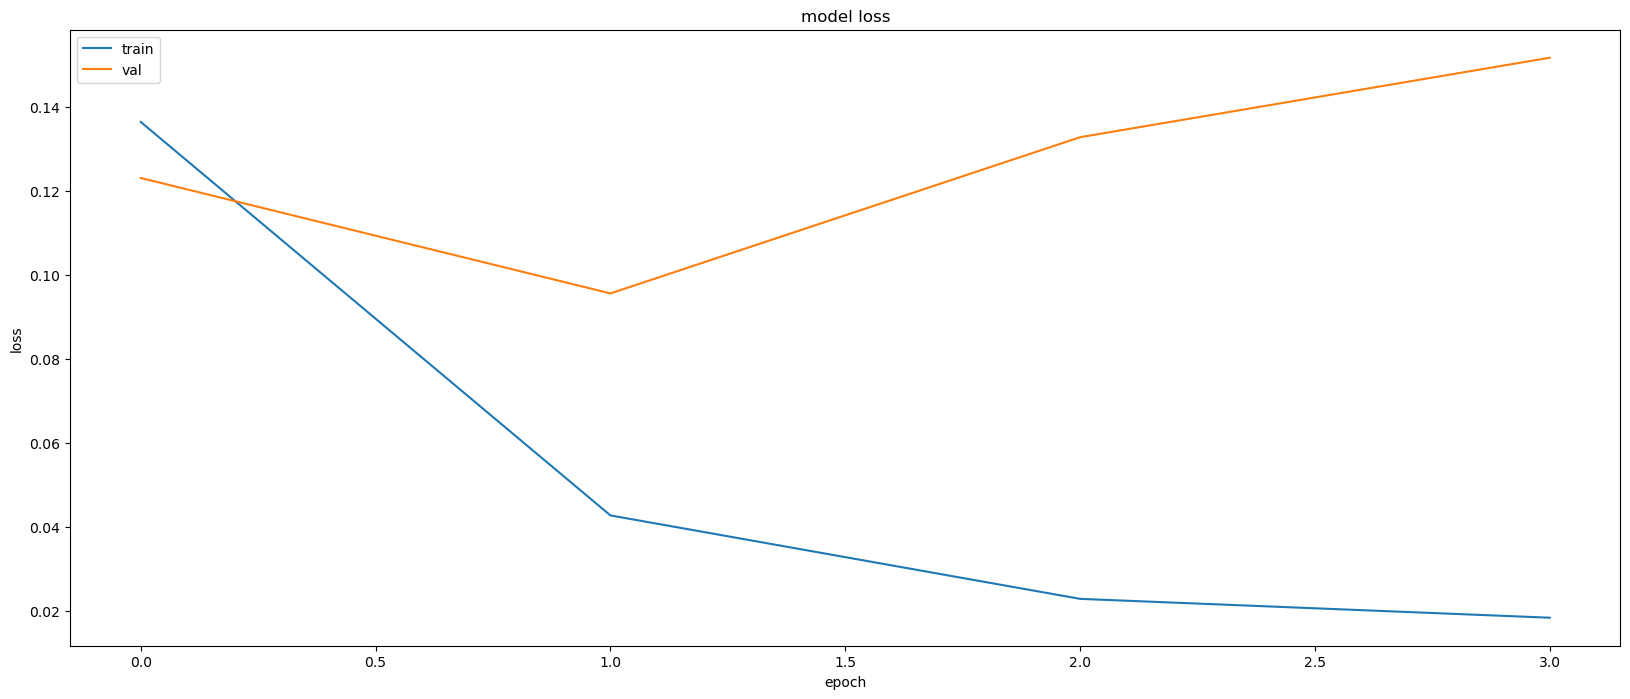

In [38]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
y_pred = model.predict(X_test)

C:\Users\User\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


281/281 [==============================] - 25s 88ms/step


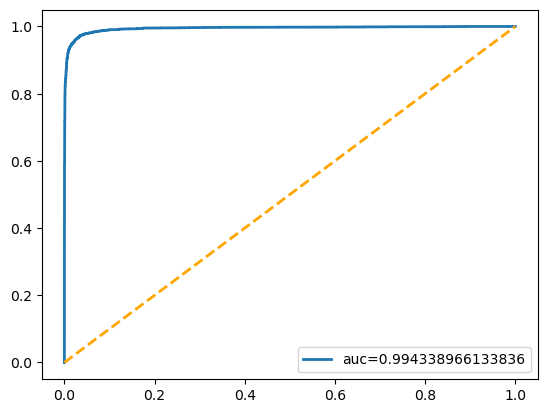

In [40]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [67]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4291
           1       0.99      0.94      0.97      4689

    accuracy                           0.96      8980
   macro avg       0.97      0.97      0.96      8980
weighted avg       0.97      0.96      0.96      8980

